## Task 6: Construct the classification machine learning model

**The purpose** of this model is to mitigate misinformation in videos on the TikTok platform.

**The goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".
<br/>

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.


A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

**What are the ethical implications of building the model?**
In the given scenario, it's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It's very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.

**The steps that i will take**

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)

In [49]:
#import necessary libraries
import pandas as pd
import numpy as np

#import package for data visualization 
import matplotlib.pyplot as plt 
import seaborn as sns 

#For data modeling and preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

#Model evaluation 
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay


In [30]:
#Load the dataset 
data = pd.read_csv(r"C:\Users\LENOVO\OneDrive\Desktop\Data analytics\Portfolio\Full_cycle projects\TikTok classification machine learning\Dataset\tiktok_dataset.csv")
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


### 1. Data inspection

In [3]:
#See the shape of data 
data.shape

(19382, 12)

In [5]:
#See data columns information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [6]:
#Check for null values 
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [31]:
#Drop any null rows
data = data.dropna(axis=0)

In [32]:
#Check for duplicates 
data.duplicated().sum()

0

In [9]:
#Get basic descriptive statistics 
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19084.000000,1.908400e+04,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9542.500000,5.624840e+09,32.423811,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5509.220604,2.537030e+09,16.226470,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4771.750000,3.425100e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9542.500000,5.609500e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14313.250000,7.840823e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19084.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [33]:
#Check for class balance. Our classes are balanced 
data['claim_status'].value_counts(normalize= True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

### 2. Feature Engineering 

In [34]:
#I extract text_length from the Video_transcription_text column  
data['text_length'] = data['video_transcription_text'].str.len()
data.head()


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [35]:
#Compare text length between claim and opinion videos 
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


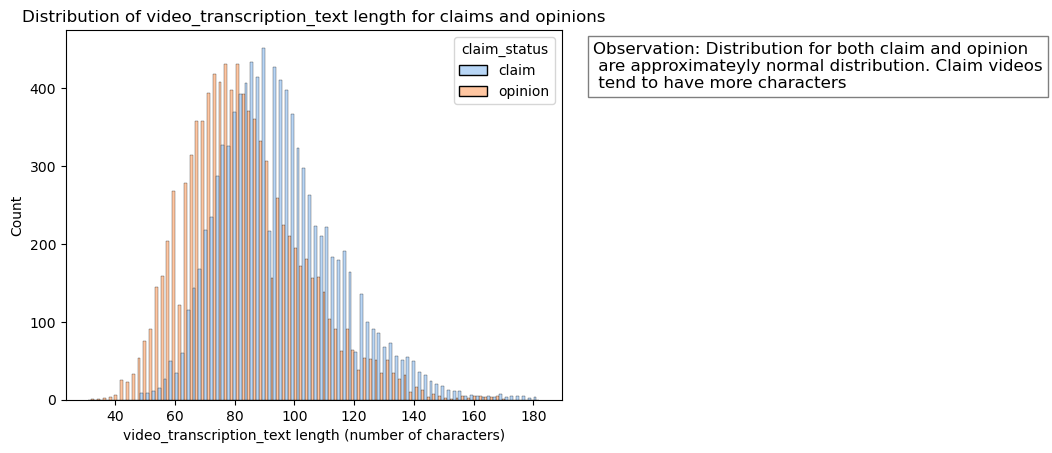

In [36]:
# Visualize the distribution of `text_length` for claims and opinions

sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")

#Add description text
plt.text(200, 400, 'Observation: Distribution for both claim and opinion\n are approximateyly normal distribution. Claim videos\n tend to have more characters', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

**Feature selection and transformation**

In [37]:
#Drop unecessary columns 
X= data.drop(['#', 'video_id'], axis=1)

#Encode categorical variables 
X['claim_status'] = X['claim_status'].map({'claim': 1, 'opinion': 0})

#Encode other categorical variables 
X = pd.get_dummies(X, columns=['verified_status', 'author_ban_status'], drop_first= True)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


In [38]:
#Change the boolean columns into numeric 
X['verified_status_verified'] = X['verified_status_verified'].astype(int)
X['author_ban_status_banned'] = X['author_ban_status_banned'].astype(int)
X['author_ban_status_under review'] = X['author_ban_status_under review'].astype(int)

X.dtypes

claim_status                        int64
video_duration_sec                  int64
video_transcription_text           object
video_view_count                  float64
video_like_count                  float64
video_share_count                 float64
video_download_count              float64
video_comment_count               float64
text_length                         int64
verified_status_verified            int32
author_ban_status_banned            int32
author_ban_status_under review      int32
dtype: object

**Split the data**

Split into training, validating, and testing data 

In [39]:
#Assign X, y variables 
y= X['claim_status']

X= X.drop(['claim_status', 'video_transcription_text'], axis= 1)
X.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,31,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,25,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,19,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


In [40]:
#Split data into training and testing data. I want 80/20 
X_tr, X_test, y_tr, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

#Split training data and validation data. We would have (60/20/20 for train/validate/test)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

#Get the shape for each dataset 
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 10), (3817, 10), (3817, 10), (11450,), (3817,), (3817,))

### 3. Construct the models

> **3.1 Build a random forest model**

In [41]:
#Instantiate the random forest classifier 
rf = RandomForestClassifier(random_state=0)

#create a list of hyperparameters to tune 
cv_params = {'max_depth': [5,7, None], 
             'max_features': [0.3, 0.6],
             'max_samples': [0.7], 
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75, 100, 200]}

#Create a list of score to search over
scoring = {'accuracy': 'accuracy', 
           'f1': 'f1', 
           'precision': 'precision', 
           'recall': 'recall'}

#instantiatet the GridSearch object 
rf_cv = GridSearchCV(rf, cv_params, scoring= scoring, cv=5, refit= 'recall')

In [42]:
#Fit the model to training data 
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [43]:
#Get the best hyperparameters from the model 
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

In [63]:
#Predict on validation data 
y_pred_rf = rf_cv.best_estimator_.predict(X_val)
y_pred_rf

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [64]:
#Get the metrics score 
print('F1 score Random Forest model: ', f1_score(y_val, y_pred_rf))
print('Recall score Random Forest: ', recall_score(y_val, y_pred_rf))
print('Precision score Random Forest: ', precision_score(y_val, y_pred_rf))
print('Accuracy score Random Forest: ', accuracy_score(y_val, y_pred_rf))

F1 score Random Forest model:  0.9934810951760106
Recall score Random Forest:  0.9896103896103896
Precision score Random Forest:  0.9973821989528796
Accuracy score Random Forest:  0.9934503536809012


**Evaluate the Random forest model**

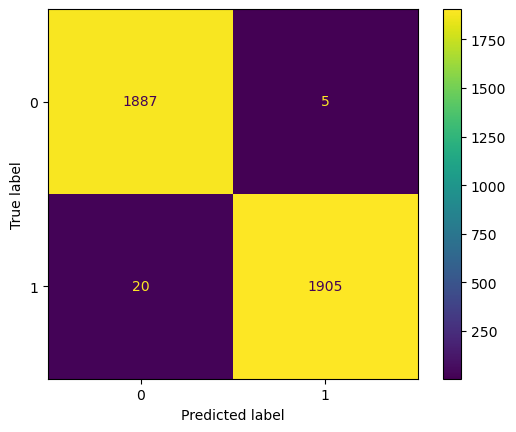

In [65]:
#Construct a confusion matrix 
cm = metrics.confusion_matrix(y_val, y_pred_rf, labels= rf_cv.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = rf_cv.classes_)
disp.plot()

Observation: our predictive Random forest model yields a pretty accurate Recall score of 0.989. In other words, among the 1925 claim videos, our model accurately predicts 1905 of claim videos.

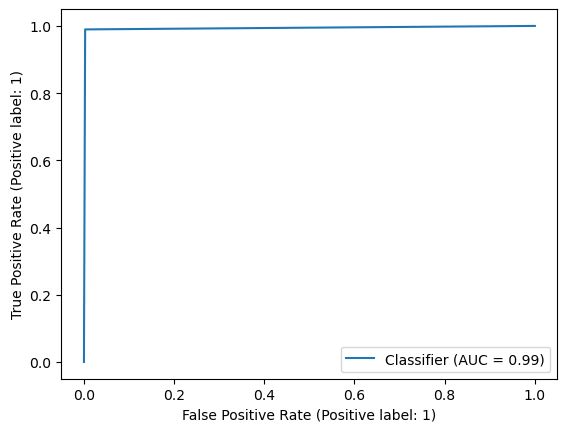

In [66]:
#Construct a ROC curve 
RocCurveDisplay.from_predictions(y_val, y_pred_rf)

plt.show()

Observation: our ROC curve shows our Random Forest model is well perfomred.

> **3.2 Build a XGBoost model to see if it outperforms the Random Forest model**

In [60]:
#Instantiate the model 
xgb = XGBClassifier(objective='binary:logistic', random_state= 0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }
#Create a list of score to search over
scoring = {'accuracy': 'accuracy', 
           'f1': 'f1', 
           'precision': 'precision', 
           'recall': 'recall'}

#instantiate the GridSearchCV object 
xgb_cv = GridSearchCV(xgb, cv_params, scoring= scoring, cv=5, refit= 'recall')

In [61]:
#Fit the model 
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [62]:
#get the best parameters 
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

In [68]:
#predict on validation dataset 
y_pred_xg = xgb_cv.predict(X_val)
y_pred_xg

array([1, 0, 1, ..., 1, 1, 1])

**Evaluate the GXBoost model**

In [72]:
#get the avaluation metrics
print('F1 score XGBoost model: ', f1_score(y_val, y_pred_xg))
print('Recall score XGBoost: ', recall_score(y_val, y_pred_xg))
print('Precision score XGBoost: ', precision_score(y_val, y_pred_xg))
print('Accuracy score XGBoost: ', accuracy_score(y_val, y_pred_xg))

F1 score XGBoost model:  0.9932150313152401
Recall score XGBoost:  0.9885714285714285
Precision score XGBoost:  0.9979024646040902
Accuracy score XGBoost:  0.9931883678281372


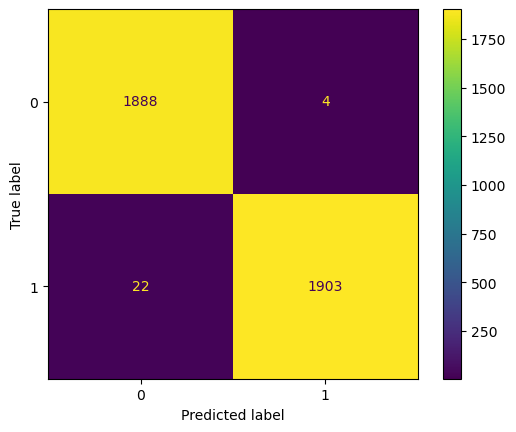

In [73]:
#Construct a confusion matrix 
cm = metrics.confusion_matrix(y_val, y_pred_gx, labels= xgb_cv.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = xgb_cv.classes_)
disp.plot()

The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better recall score, and is therefore the champion model.

### 4. Use the champion model to predict on test data 

In [71]:
#Use Random Forest model to predict on testing data 
y_pred_final = rf_cv.predict(X_test)

In [75]:
#get the evaluation metrics
print('F1 score Random Forest model: ', f1_score(y_test, y_pred_final))
print('Recall score Random Forest: ', recall_score(y_test, y_pred_final))
print('Precision score Random Forest: ', precision_score(y_test, y_pred_final))
print('Accuracy score Random Forest: ', accuracy_score(y_test, y_pred_final))

F1 score Random Forest model:  0.994953519256308
Recall score Random Forest:  0.9915299100052938
Precision score Random Forest:  0.9984008528784648
Accuracy score Random Forest:  0.9950222687974849


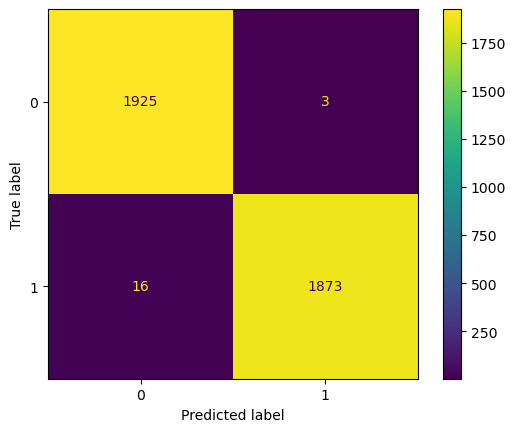

In [76]:
#Construct a confusion matrix 
cm = metrics.confusion_matrix(y_test, y_pred_final, labels= xgb_cv.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = None)
disp.plot()

**Find the feature importance of champion model**

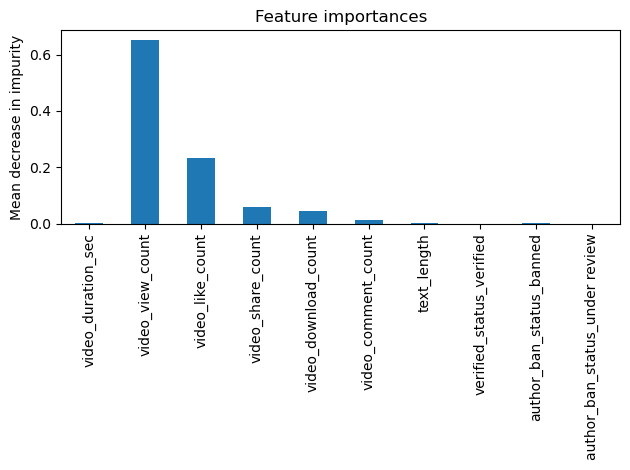

In [77]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

## Summary

After the modeling process, I believe the Random Forest is the most suitable for our predictive model. One can use this model to predict whether the video is about a claim or opinion. The model very successfully classified claims and opinions with high Recall score. The model's most predictive features were all related to the user engagement levels associated with each video, specifically views, likes, shares, and downloads.  